In [16]:
import torch
import pandas as pd
import numpy
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [4]:
df = pd.read_csv("../data/data_modbus_setpoint_TP_1min.csv")

In [5]:
df

,Timestamp,T1,T2,T3,T4,T5,I,V,PID set value,DMC set value,data set-value,FLU,FRU,FLB,FRB,HL,HR
0,1675180114441,4800,4012,3381,2681,2600,428,964,4500,4300,1,231,233,0,0,732,106
1,1675180174504,5031,4118,3343,2712,2612,420,965,4500,4300,1,231,233,0,0,732,106
2,1675180234459,5156,4187,3356,2750,2625,406,965,4500,4300,1,231,233,0,0,732,106
3,1675180294518,5200,4225,3368,2756,2618,419,965,4500,4300,1,231,233,0,0,732,106
4,1675180354473,5256,4243,3375,2781,2631,399,965,4500,4300,1,231,233,0,0,732,106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2873,1675352614528,7337,5131,4468,2743,2637,410,964,4500,4300,1,11,693,0,0,790,740
2874,1675352674484,6387,4818,4468,2712,2650,728,962,4500,4300,1,11,693,0,0,790,740
2875,1675352734452,6606,4837,4418,2681,2650,725,961,4500,4300,1,11,693,0,0,790,740
2876,1675352794513,7168,5056,4450,2725,2656,711,961,4500,4300,1,11,693,0,0,790,740


In [7]:
df["PID set value"].value_counts()

PID set value
4000    1228
4500     830
3500     410
3000     410
Name: count, dtype: int64

In [8]:
df.drop(["PID set value","DMC set value", "data set-value"], axis=1, inplace=True)

In [9]:
df

,Timestamp,T1,T2,T3,T4,T5,I,V,FLU,FRU,FLB,FRB,HL,HR
0,1675180114441,4800,4012,3381,2681,2600,428,964,231,233,0,0,732,106
1,1675180174504,5031,4118,3343,2712,2612,420,965,231,233,0,0,732,106
2,1675180234459,5156,4187,3356,2750,2625,406,965,231,233,0,0,732,106
3,1675180294518,5200,4225,3368,2756,2618,419,965,231,233,0,0,732,106
4,1675180354473,5256,4243,3375,2781,2631,399,965,231,233,0,0,732,106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2873,1675352614528,7337,5131,4468,2743,2637,410,964,11,693,0,0,790,740
2874,1675352674484,6387,4818,4468,2712,2650,728,962,11,693,0,0,790,740
2875,1675352734452,6606,4837,4418,2681,2650,725,961,11,693,0,0,790,740
2876,1675352794513,7168,5056,4450,2725,2656,711,961,11,693,0,0,790,740


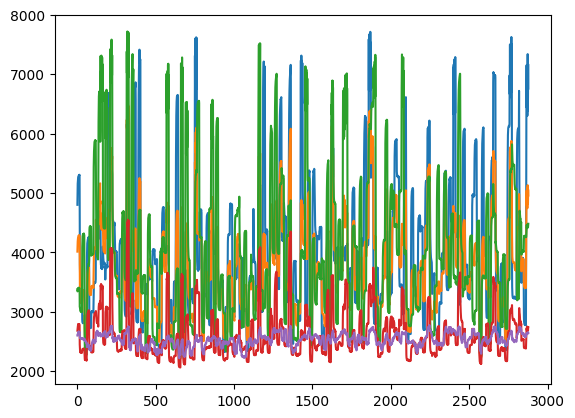

In [43]:
plt.plot(df["T1"])
plt.plot(df["T2"])
plt.plot(df["T3"])
plt.plot(df["T4"])
plt.plot(df["T5"])

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [39]:
class ExperimentDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


    def __len__(self):
        return len(self.X)

In [34]:
df.keys()

Index(['Timestamp', 'T1', 'T2', 'T3', 'T4', 'T5', 'I', 'V', 'FLU', 'FRU',
       'FLB', 'FRB', 'HL', 'HR'],
      dtype='object')

In [35]:
X_train, X_test, y_train, y_test = train_test_split(df[["I","V","FLU" ,"FRU","FLB" ,"FRB", "HL", "HR" ]], df[["T1", "T2", "T3", "T4", "T5"]], test_size = 0.2, random_state = 42)

In [36]:
train_dataset = pd.concat([X_train, y_train], axis =1)
valid_dataset = pd.concat([X_test, y_test], axis = 1)

In [37]:
train_dataset.dtypes

I      int64
V      int64
FLU    int64
FRU    int64
FLB    int64
FRB    int64
HL     int64
HR     int64
T1     int64
T2     int64
T3     int64
T4     int64
T5     int64
dtype: object

In [38]:
train_dataset.iloc[:,0:-5].dtypes

I      int64
V      int64
FLU    int64
FRU    int64
FLB    int64
FRB    int64
HL     int64
HR     int64
dtype: object

In [42]:
train_dataset = ExperimentDataset(train_dataset.iloc[:,0:-5].values, train_dataset.iloc[:, -5:].values)